In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from tqdm import tqdm

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

%load_ext autoreload
%autoreload 2
from utils import show_heat_map, print_mutual_info, aggregate_data, resample_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Index(['time', 'mid', 'bidsize_1', 'bidsize_5', 'bidsize_10', 'bidsize_20',
       'bidsize_40', 'asksize_1', 'asksize_5', 'asksize_10', 'asksize_20',
       'asksize_40', 'trade_side', 'trade_size', 'trade_price'],
      dtype='object')

In [6]:
def process(df_raw):
    df_raw = df_raw[['time', 'mid', 'trade_side', 'trade_size', 'trade_price']]
    # display(df_raw)

    df_raw['mul'] = df_raw['trade_size'] * df_raw['trade_price']
    df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')

    # Group by 'time' and conditionally sum 'A' based on 'B' == 'X'
    df_buy = df_raw[df_raw['trade_side'] == 'Buy'].groupby('time', as_index=False).agg(
        trade_mul_sum=('mul', 'sum'),
        trade_size_sum=('trade_size', 'sum'),
    )
    df_sell = df_raw[df_raw['trade_side'] == 'Sell'].groupby('time', as_index=False).agg(
        trade_mul_sum=('mul', 'sum'),
        trade_size_sum=('trade_size', 'sum'),
    )

    df_buy.set_index('time', inplace=True)
    df_sell.set_index('time', inplace=True)

    df_ob = df_raw[df_raw['trade_side'].isna()].drop(columns=['trade_side', 'trade_size', 'trade_price'])
    df_ob.set_index('time', inplace=True)

    time_step = '1T'
    # SUM_TRADE_SIZE = df_raw['trade_size'].sum()
    df_buy_resampled = df_buy.resample(time_step).agg({
            'trade_size_sum': 'sum',  # Sum for size
            'trade_mul_sum': 'sum',  # Min for min price
        }).rename(columns={'trade_size_sum': 'buy_size', 'trade_mul_sum': 'buy_mul'})
    df_sell_resampled = df_sell.resample(time_step).agg({
            'trade_size_sum': 'sum',  # Sum for size
            'trade_mul_sum': 'sum',  # Min for min price
        }).rename(columns={'trade_size_sum': 'sell_size', 'trade_mul_sum': 'sell_mul'})
    df_ob_resampled = df_ob.resample(time_step).last()
    df = df_ob_resampled.join(df_buy_resampled.join(df_sell_resampled, how='outer'), how='outer')

    for col in ['buy_size', 'sell_size']:
        df[col] = df[col].fillna(0)

    for col in ['mid']:
        df[col] = df[col].ffill()  
    return df

<ipython-input-6-c68204f13e5f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['mul'] = df_raw['trade_size'] * df_raw['trade_price']
<ipython-input-6-c68204f13e5f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')


In [13]:
start_date_str = "20250213"
end_date_str = "20250314"
name_template = "output_2025-03-15_{}_HYPEUSDTOB500_HYPEUSDTtrades_VX.csv"

big_df = []

start_date = datetime.strptime(start_date_str, "%Y%m%d")
end_date = datetime.strptime(end_date_str, "%Y%m%d")

date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

for date in tqdm(date_range):
    date_str = date.strftime('%Y%m%d')
    filename = name_template.format(date_str)
    df_raw = pd.read_csv(f"../simulation_data/{filename}")
    df = process(df_raw)
    # df_buy, df_sell, df_ob = aggregate_data(df_raw)
    # df = resample_df(df_buy, df_sell, df_ob, '30s')
    big_df.append(df)

df = pd.concat(big_df, axis=0, ignore_index=False)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-6-c68204f13e5f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['mul'] = df_raw['trade_size'] * df_raw['trade_price']
<ipython-input-6-c68204f13e5f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')
100%|██████████| 30/30 [01:50<00:00,  3.68s/it]


In [32]:
df['vwap'] = (df['buy_mul'] + df['sell_mul']) / (df['buy_size'] + df['sell_size'])
df['alpha1'] = df['vwap'] - df['mid']
df['alpha1'] = df['alpha1'].ewm(span=3, adjust=False).mean()
df['mid_return_1m'] = np.log(df['mid'].shift(-1) / df['mid'])
df

,mid,mul,buy_size,buy_mul,sell_size,sell_mul,vwap,alpha1,mid_return_1m,mean,std,return,signal_sell,signal_buy,signal,pnl,alpha2
time,,,,,,,,,,,,,,,,,
2025-02-13 00:00:00,25.8465,NaN,1902.70,49216.10132,6018.98,155684.17131,25.865760,0.019260,-0.001006,NaN,NaN,-0.001006,-0.0,-0.0,0.0,-0.000000,0.019260
2025-02-13 00:01:00,25.8205,NaN,1118.36,28889.21300,709.46,18329.46363,25.833330,0.016045,0.000155,NaN,NaN,0.000155,-0.0,-0.0,0.0,0.000000,0.016045
2025-02-13 00:02:00,25.8245,NaN,1286.71,33219.40806,654.15,16886.06062,25.816117,0.003831,-0.001705,NaN,NaN,-0.001704,-0.0,-0.0,0.0,0.000000,0.003831
2025-02-13 00:03:00,25.7805,NaN,293.54,7570.30155,484.49,12502.14999,25.799071,0.011201,-0.002136,NaN,NaN,-0.002133,-0.0,-0.0,0.0,0.000000,0.011201
2025-02-13 00:04:00,25.7255,NaN,475.58,12248.08295,1493.81,38474.29326,25.755374,0.020538,-0.000778,NaN,NaN,-0.000777,-0.0,-0.0,0.0,0.000000,0.020538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-14 23:56:00,13.7685,NaN,522.18,7185.37513,672.65,9253.96884,13.758731,-0.004806,0.000871,0.000965,0.013203,0.000872,-0.0,-0.0,0.0,-28951.513474,-0.004806
2025-03-14 23:57:00,13.7805,NaN,698.14,9618.94732,462.82,6380.69636,13.781391,-0.001957,0.001305,0.000995,0.013196,0.001306,-0.0,-0.0,0.0,-28951.513474,-0.001957
2025-03-14 23:58:00,13.7985,NaN,1719.86,23720.08861,651.04,8979.00932,13.791850,-0.004304,0.000652,0.001058,0.013129,0.000652,-0.0,-0.0,0.0,-28951.513474,-0.004304


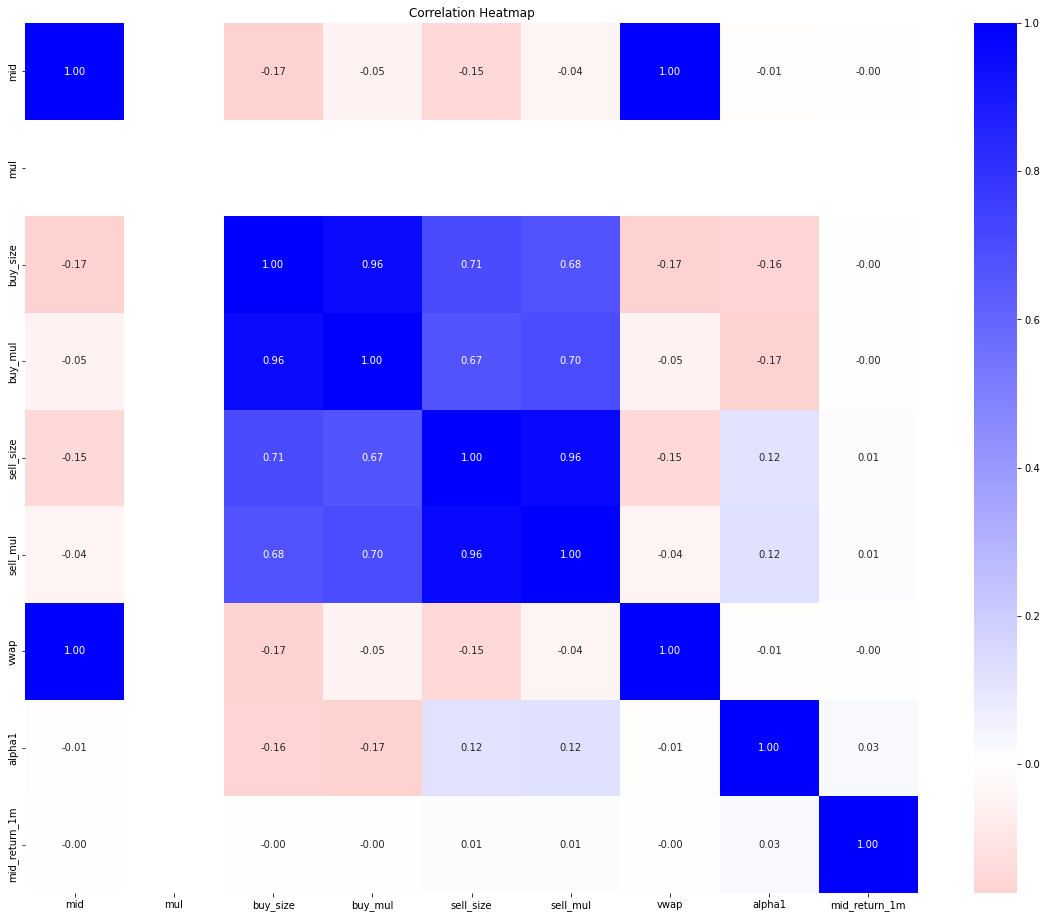

In [16]:
show_heat_map(df)

In [30]:
# df['alpha1'] = df['vwap'] - df['mid']
df['mean'] = df['alpha1'].rolling(200).mean()
df['std'] = df['alpha1'].rolling(200).std()
df['return'] = (df['mid'].shift(-1) - df['mid']) / df['mid']

df['signal_sell'] = (df['alpha1'] - df['mean'] > df['std'] * 2) * -1.0
df['signal_buy'] = (df['alpha1'] - df['mean'] < df['std'] * -2) * -1.0
df['signal'] = df['signal_buy'] - df['signal_sell']

df['pnl'] = (df['signal'] * df['return'] - df['signal'].abs() * 14.0).cumsum()

df

,mid,mul,buy_size,buy_mul,sell_size,sell_mul,vwap,alpha1,mid_return_1m,mean,std,return,signal_sell,signal_buy,signal,pnl,alpha2
time,,,,,,,,,,,,,,,,,
2025-02-13 00:00:00,25.8465,NaN,1902.70,49216.10132,6018.98,155684.17131,25.865760,0.019260,-0.001006,NaN,NaN,-0.001006,-0.0,-0.0,0.0,-0.000000,0.019260
2025-02-13 00:01:00,25.8205,NaN,1118.36,28889.21300,709.46,18329.46363,25.833330,0.012830,0.000155,NaN,NaN,0.000155,-0.0,-0.0,0.0,0.000000,0.016045
2025-02-13 00:02:00,25.8245,NaN,1286.71,33219.40806,654.15,16886.06062,25.816117,-0.008383,-0.001705,NaN,NaN,-0.001704,-0.0,-0.0,0.0,0.000000,0.003831
2025-02-13 00:03:00,25.7805,NaN,293.54,7570.30155,484.49,12502.14999,25.799071,0.018571,-0.002136,NaN,NaN,-0.002133,-0.0,-0.0,0.0,0.000000,0.011201
2025-02-13 00:04:00,25.7255,NaN,475.58,12248.08295,1493.81,38474.29326,25.755374,0.029874,-0.000778,NaN,NaN,-0.000777,-0.0,-0.0,0.0,0.000000,0.020538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-14 23:56:00,13.7685,NaN,522.18,7185.37513,672.65,9253.96884,13.758731,-0.009769,0.000871,0.000965,0.013203,0.000872,-0.0,-0.0,0.0,-28951.513474,-0.004806
2025-03-14 23:57:00,13.7805,NaN,698.14,9618.94732,462.82,6380.69636,13.781391,0.000891,0.001305,0.000995,0.013196,0.001306,-0.0,-0.0,0.0,-28951.513474,-0.001957
2025-03-14 23:58:00,13.7985,NaN,1719.86,23720.08861,651.04,8979.00932,13.791850,-0.006650,0.000652,0.001058,0.013129,0.000652,-0.0,-0.0,0.0,-28951.513474,-0.004304


<Axes: xlabel='time'>

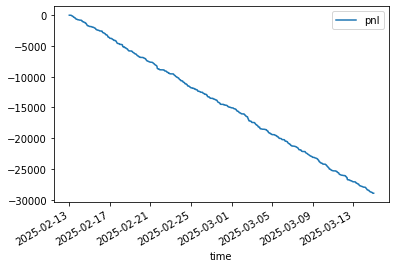

In [31]:
df[['pnl']].plot()

<Axes: xlabel='time'>

<Figure size 14400x3600 with 0 Axes>

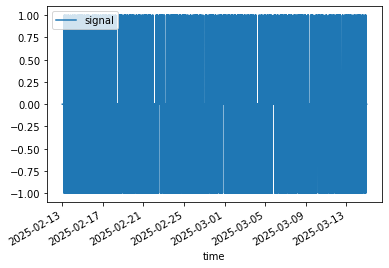

In [19]:
plt.figure(figsize=(200, 50))
df[['signal']].plot()

In [20]:
df['signal'].abs().sum()

2350.0

<Axes: xlabel='time'>

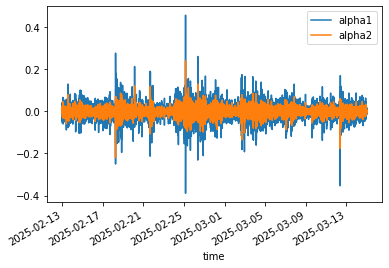

In [21]:
df['alpha1'] = df['vwap'] - df['mid']
df['alpha2'] = df['alpha1'].ewm(span=3, adjust=False).mean()

df[['alpha1', 'alpha2']].plot()

-3.0840441265690997
2.4687106685480735


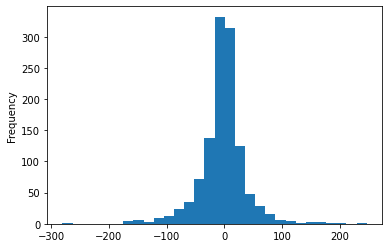

In [29]:
(df[df['signal'] == -1.0]['return'] * 10000.0).plot(kind='hist', bins = 30)
print(df[df['signal'] == -1.0]['return'].mean() * 10000.0)
print(df[df['signal'] == 1.0]['return'].mean() * 10000.0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='signal', ylabel='return'>

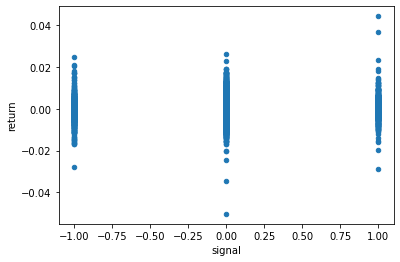

In [27]:
df.plot(x='signal', y='return', kind='scatter')